In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

DATA_PATH = '../data/final_dataset.csv'
df = pd.read_csv(DATA_PATH)

#We will see the data thoroughly through a sample
print("Sample data:")
display(df.head())
#To see data types in the data and also to see the counting of the non null values for performing necessary transformations on data
print("\nINFO:")
df.info()
#We will check how many missing values are there
print("\n--- Missing Values Check ---")
print(df.isnull().sum())

In [32]:
#Nice design
sns.set_theme(style="whitegrid",palette="viridis")
# sns.set_theme(style="whitegrid")
plt.rc('figure',dpi=100,figsize=(10, 6))

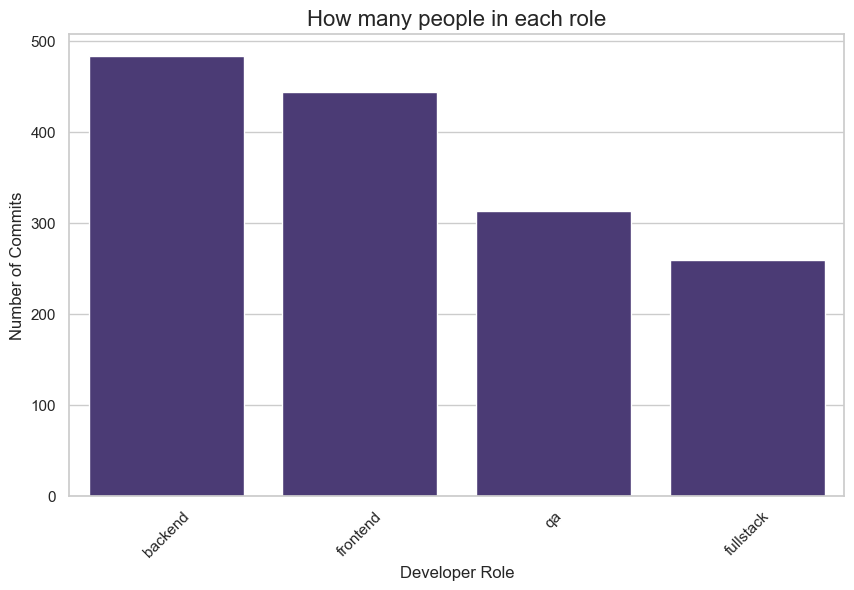

Number of people in each of the role:
role
backend      484
frontend     444
qa           313
fullstack    259
Name: count, dtype: int64


In [33]:
#Since there are no null values, we do not have to handle null data. Otherwise there are methods such as:
#deleting the null data(only when there is less number of null value);replacing the NULL with the mean or median or mode,etc
#Now we will see for irregularity in the data and label imbalances by plotting graphs for it
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='role', order=df['role'].value_counts().index)
plt.title('How many people in each role',fontsize=16)
plt.xlabel('Developer Role',fontsize=12)
plt.ylabel('Number of Commits', fontsize=12)
plt.xticks(rotation=45)
plt.show()

print("Number of people in each of the role:")
print(df['role'].value_counts())

role             backend  frontend  fullstack   qa
extensions_list                                   
css                   35       120         70   22
html                  42       118         56   33
java_go              148        28         58   25
js_ts                 64       187        132   59
md                    12        13         11    4
py                   240        49        101   44
sql                  103        18         45   18
test_js               16        38         40  133
test_py               16        12         19  109
yml_json              18        23         26   46


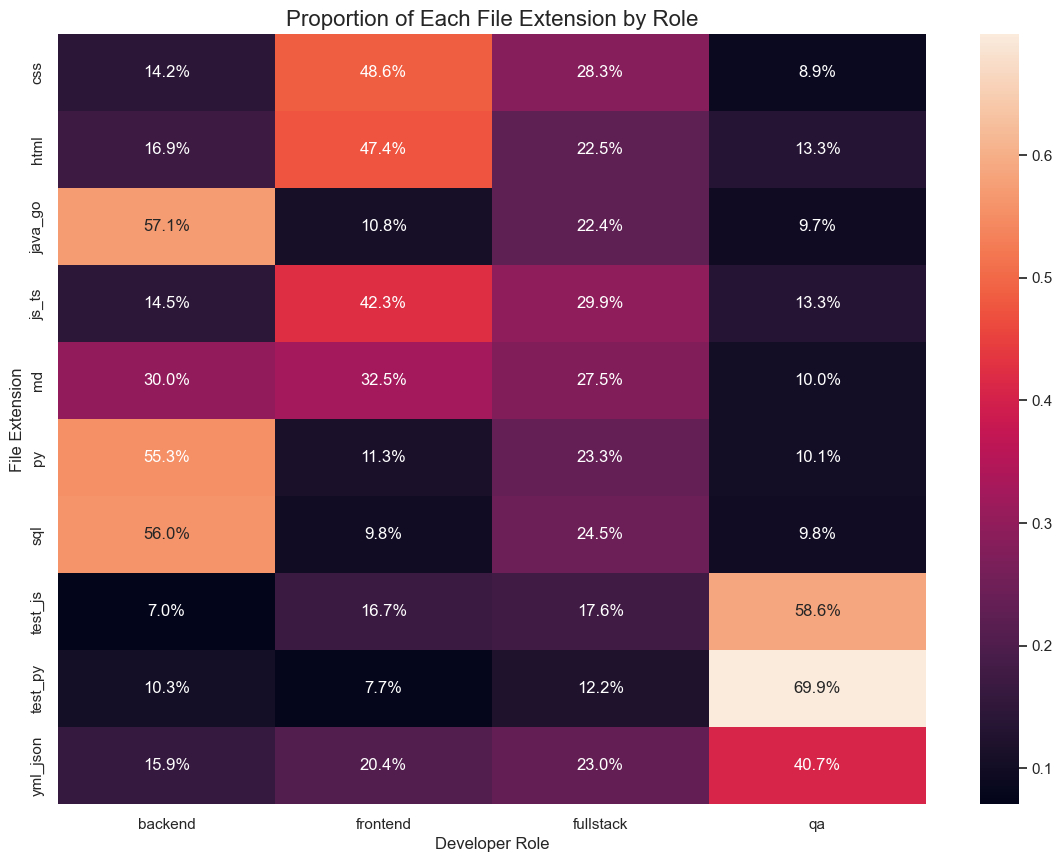

In [64]:
# As we can see from the above graph,the number of roles for full stack is very very less compared to the number of roles of backend and frontend.
#We will have to handle this label imbalance
#Analyze File Extensions vs. Role

#the below function handles the "np.str_('content')" format
def parse_extensions(file_ext):
    try:
        #A simple string replacement is safer than evaluation
        #for example we have [np.str_('js_ts')]	 so we will have to remove np.str_(' this whole part and add normal ' used for strings
        #same for ') we will remove it and add ' instead
        #so it becomes '' enclosed just like strings are
        cleaned_string =file_ext.replace("np.str_('", "'").replace("')", "'")
        # as we can see "[np.str_('js_ts'), np.str_('html')]" after replacement will become "'js_ts' ,'html'" so now to convert this into anobject to work on it
        ext_list =ast.literal_eval(cleaned_string)
        #If it is still not converted to a list, we add []
        return ext_list if isinstance(ext_list, list) else [ext_list]
    except (ValueError, SyntaxError):
        #Just incase of error we return empty list to avoid problem
        return []

#we also add column to data after applying the function commands
df['extensions_list']=df['fileextensions'].apply(parse_extensions)


df_exploded =df.explode('extensions_list')
extension_role_counts =pd.crosstab(df_exploded['extensions_list'], df_exploded['role'])
print(extension_role_counts)

#Normalize data by value/sum of row 
plt.figure(figsize=(14, 10))
sns.heatmap(
    extension_role_counts.apply(lambda r: r/r.sum(), axis=1),
    annot=True,
    fmt=".1%"
)
plt.title('Proportion of Each File Extension by Role', fontsize=16)
plt.xlabel('Developer Role', fontsize=12)
plt.ylabel('File Extension', fontsize=12)
plt.show()

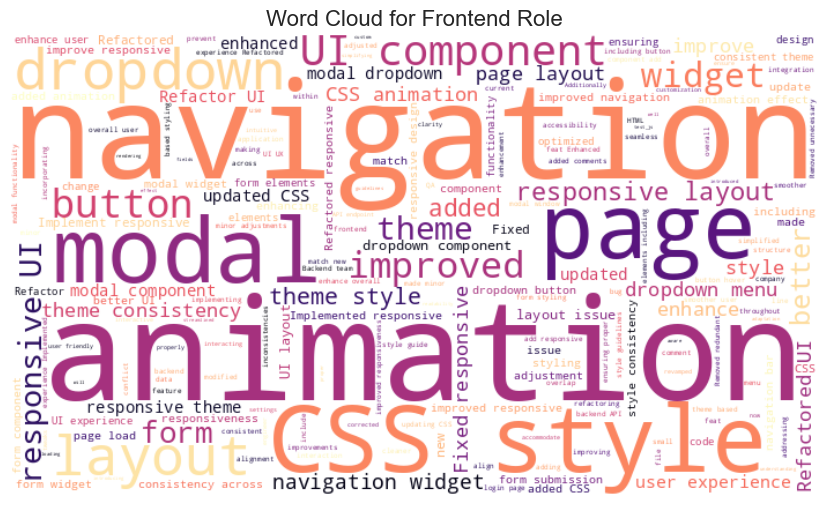

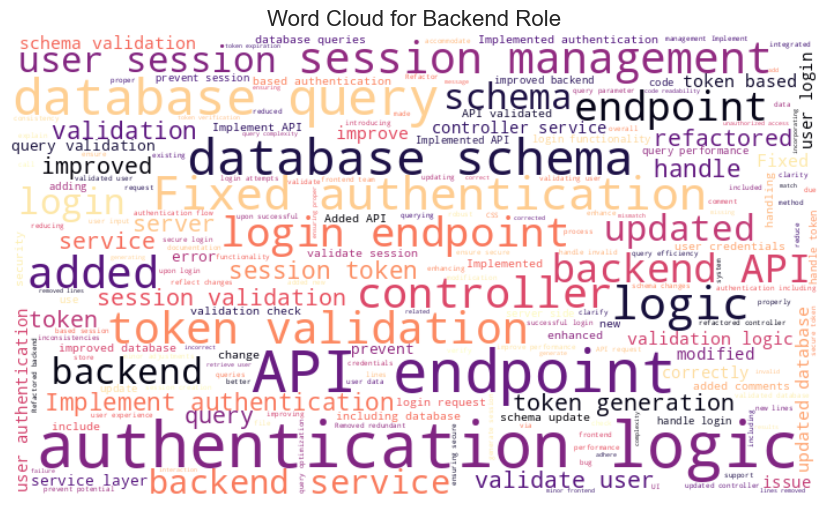

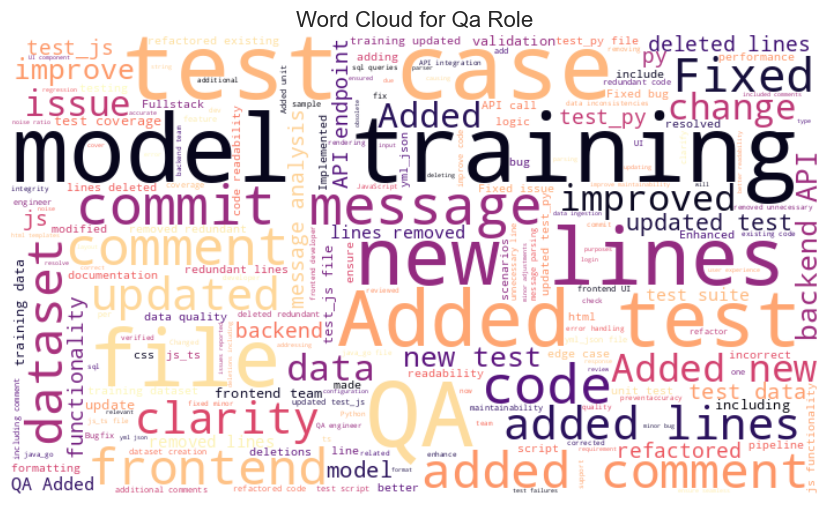

In [58]:
#Analyze Commit Message Content

from wordcloud import WordCloud

def plot_wordcloud_for_role(df, role_name):
    """
    Filters the DataFrame for a specific role, concatenates all commit messages,
    and generates a word cloud visualization.
    """
    # Combine all commit messages for the specified role into one large string
    text = ' '.join(df[df['role'] == role_name]['commitmessage'].astype(str))
    
    # Generate the word cloud object
    wordcloud = WordCloud(
        width=700, 
        height=400, 
        background_color='white',
        colormap='magma',
        contour_width=1,
        contour_color='steelblue'
    ).generate(text)
    
    #Plot
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # Hide the axes
    plt.title(f'Word Cloud for {role_name.capitalize()} Role', fontsize=16)
    plt.show()

#generate word clouds
plot_wordcloud_for_role(df, 'frontend')
print('\n\n')
plot_wordcloud_for_role(df, 'backend')
print('\n\n')
plot_wordcloud_for_role(df, 'qa')

Numbered Features


,numfileschanged,linesadded,linesdeleted,numcommentsadded
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,3.810667,183.698667,92.474000,3.164667
std,2.544891,258.709634,150.131266,1.891367
min,1.000000,8.000000,1.000000,0.000000
25%,2.000000,54.000000,17.000000,2.000000
50%,3.000000,103.000000,45.000000,3.000000
75%,5.000000,206.250000,102.000000,4.000000
max,18.000000,3038.000000,1992.000000,12.000000


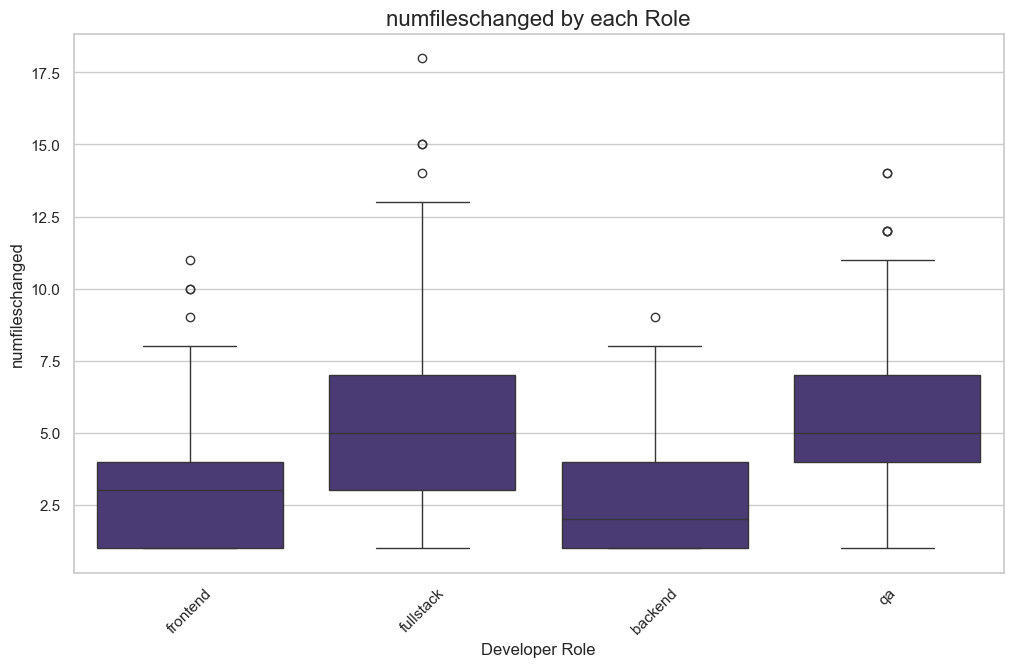

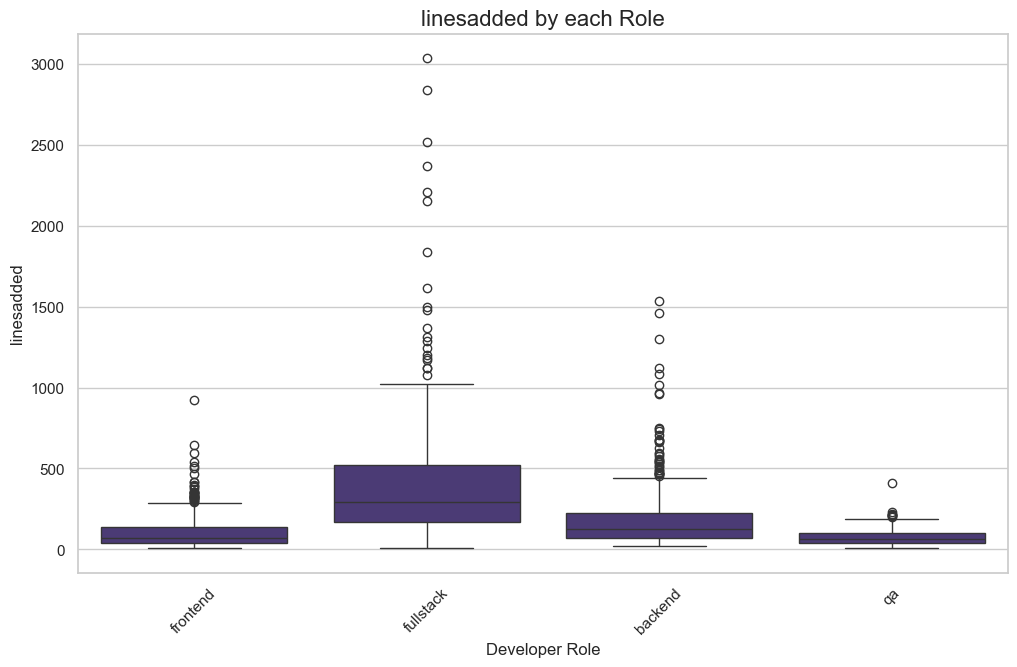

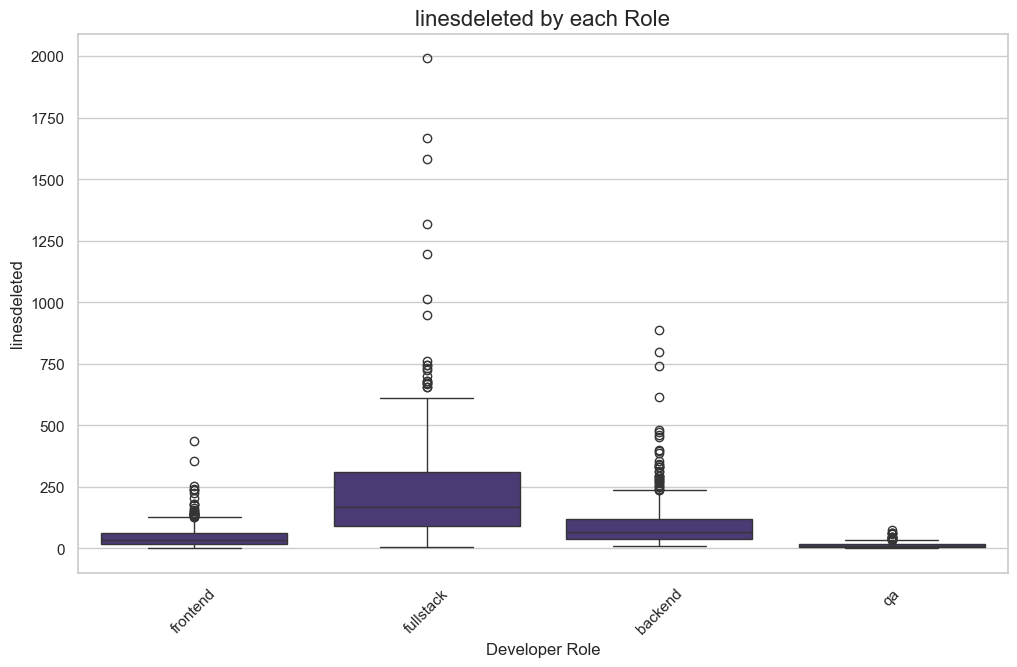

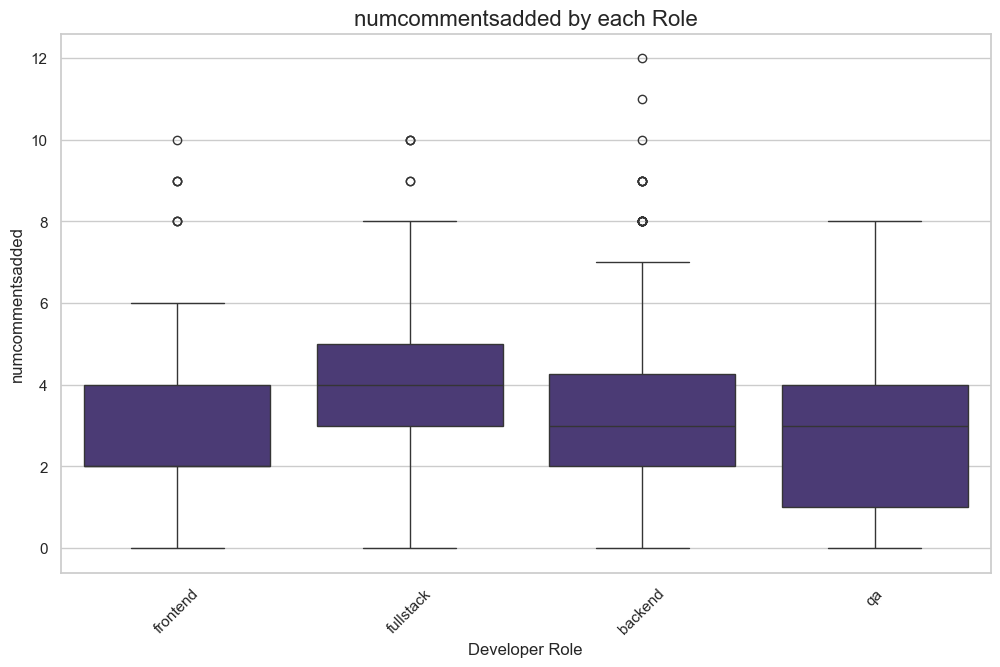

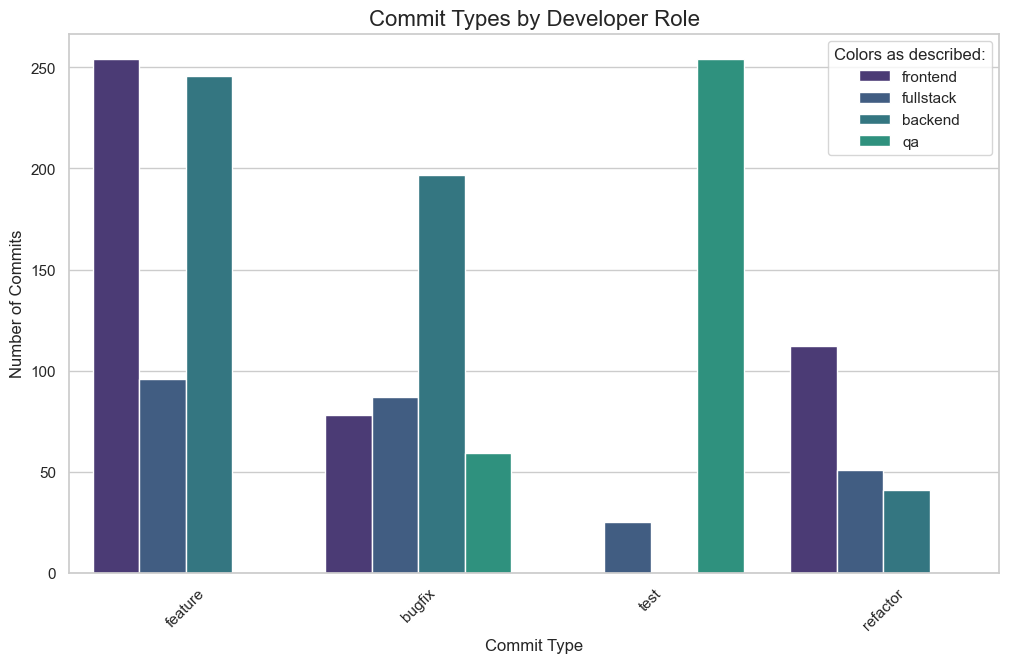

In [65]:
#Now we will analyze numbered data(or categorical; since categories are numbers too after encoding)
number_features =['numfileschanged', 'linesadded', 'linesdeleted', 'numcommentsadded']

print("Numbered Features")
display(df[number_features].describe())

# boxplot to see the distribution of numerical feature per role and also we can see outliers
for col in numeric_features:
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=df, x='role', y=col) 
    plt.title(f'{col} by each Role', fontsize=16)
    plt.xlabel('Developer Role', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

# Commit type feature analysis
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='committype', hue='role', order=df['committype'].value_counts().index)
plt.title('Commit Types by Developer Role', fontsize=16)
plt.xlabel('Commit Type', fontsize=12)
plt.ylabel('Number of Commits', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Colors as described:')
plt.show()

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

features =['committype','numfileschanged','linesadded','linesdeleted','numcommentsadded','commitmessage','extensions_list']
X =df[features]
y =df['role']

#Ordinal encoding the categorical columns
le =LabelEncoder()
y_encoded =le.fit_transform(y)
print("Label Encoding Mapping:")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name} = {i}")

#performing train_test_split
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, 
    y_encoded, 
    test_size=0.2,
    random_state=2,
    stratify=y_encoded 
)
#as we saw above, that fullstack data was less than frontend and others, we have used stratify for equal data distribution in train and test splits

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Label Encoding Mapping:
backend = 0
frontend = 1
fullstack = 2
qa = 3

Training set shape: (1200, 7)
Testing set shape: (300, 7)


In [47]:
X_train

,committype,numfileschanged,linesadded,linesdeleted,numcommentsadded,commitmessage,extensions_list
911,test,11,103,16,5,"""Enhanced test coverage for backend API endpoi...","[test_py, js_ts, sql, sql, js_ts, java_go, jav..."
1151,feature,2,42,23,5,Implemented authentication logic in the server...,"[java_go, py]"
792,test,8,58,9,3,"""Added test cases for model training (#8) and ...","[test_py, sql, py]"
852,feature,2,170,54,3,"""Refactored modal component to improve respons...",[css]
1256,refactor,6,148,103,4,Refactored UI component layout to improve resp...,"[js_ts, py, css]"
...,...,...,...,...,...,...,...
132,feature,2,109,59,1,"""Implement API endpoint for user authenticatio...",[java_go]
262,test,9,42,6,3,"""QA: Update test_js with 42 new lines and 6 de...",[test_js]
1323,test,1,28,5,6,Added test cases for js component with 23 new ...,[test_js]
304,feature,6,179,83,2,"""Implement backend authentication logic: \n- A...","[py, java_go, js_ts]"


In [79]:
#Build a Pipeline that can be used with all and only minor changes required
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
text_transformer = TfidfVectorizer(stop_words='english', max_features=1000)

#this is a mini-pipeline: first join the list into a string, then apply TF-IDF.
extensions_transformer = Pipeline(steps=[
    # The fix is to add `feature_names_out='one-to-one'` here
    ('joiner', FunctionTransformer(lambda x: x.apply(' '.join), feature_names_out='one-to-one')),
    ('tfidf', TfidfVectorizer(max_features=50))
])

#ew will now define which columns each transformer should apply to
numeric_features = ['numfileschanged', 'linesadded', 'linesdeleted', 'numcommentsadded']
categorical_features = ['committype']
text_features = 'commitmessage'
extension_features = 'extensions_list'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', text_transformer, text_features),
        ('ext', extensions_transformer, extension_features)
    ],
    remainder='drop'
)

Done with the training

Baseline Model: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        97
           1       0.97      0.99      0.98        89
           2       0.98      0.92      0.95        52
           3       1.00      1.00      1.00        62

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300

Primary Metric (Macro F1 Score): 0.9808

Confusion Matrix:


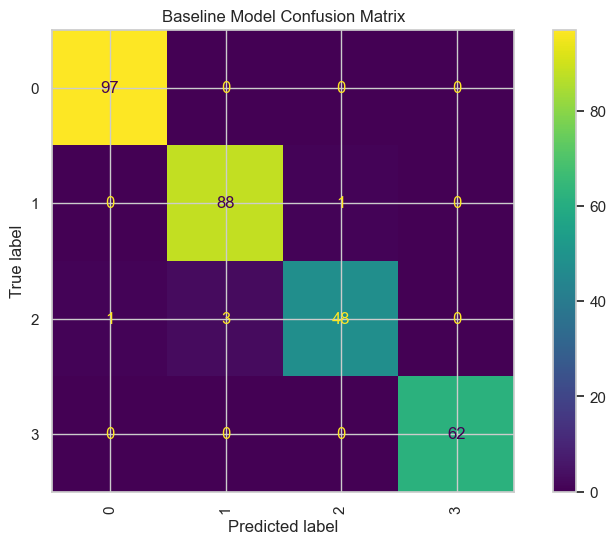

In [67]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay

#Now full pipeline is created with preprocessing and classifier
baseline_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000)) # Increased max_iter for convergence
])
#Training the full pipeline that is created above on training data 
baseline_model.fit(X_train, y_train_encoded)
print("Done with the training")

#let the model make predictions on test data(which is unseen as we have handled data leakage)
y_pred_base = baseline_model.predict(X_test)

print("\nBaseline Model: Logistic Regression")

#print the detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_base))

# calculate and print the primary metric: Macro F1 Score
macro_f1_base = f1_score(y_test_encoded, y_pred_base, average='macro')
print(f"Primary Metric (Macro F1 Score): {macro_f1_base:.4f}")

#confusion matrix plotting to visualize errors
print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_estimator(baseline_model, X_test, y_test_encoded, xticks_rotation='vertical')
plt.title('Baseline Model Confusion Matrix')
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8620
[LightGBM] [Info] Number of data points in the train set: 1200, number of used features: 175
[LightGBM] [Info] Start training from score -1.131652
[LightGBM] [Info] Start training from score -1.217959
[LightGBM] [Info] Start training from score -1.757358
[LightGBM] [Info] Start training from score -1.564624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

C:\Users\mazar\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\mazar\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


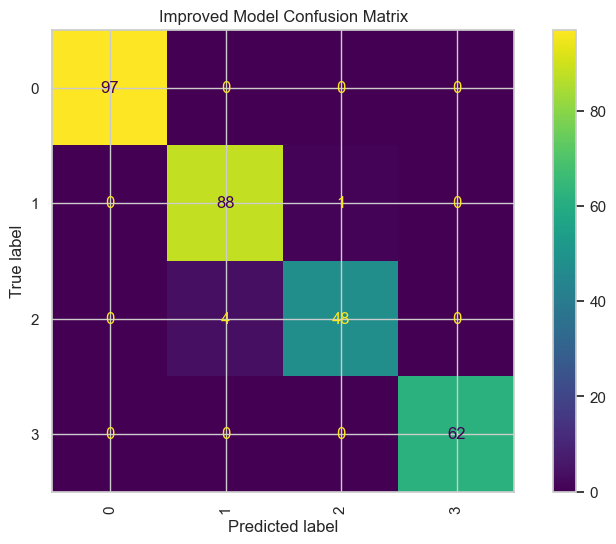

In [61]:
#LightGBM Model

import lightgbm as lgb

# The only change we will now make is the classifier at the end
improved_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(random_state=42))
])

#Training
improved_model.fit(X_train, y_train_encoded)
print("Done with the training")

#let the model make predictions on test data(which is unseen as we have handled data leakage)
y_pred_improved = improved_model.predict(X_test)

print("\nModel: LightGBM")

# Print the detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_improved))

# Calculate and print the primary metric: Macro F1 Score
macro_f1_improved = f1_score(y_test_encoded, y_pred_improved, average='macro')
print(f"Primary Metric (Macro F1 Score): {macro_f1_improved:.4f}")

# confusion matrix plotting to visualize errors
print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_estimator(improved_model, X_test, y_test_encoded, xticks_rotation='vertical')
plt.title('Improved Model Confusion Matrix')
plt.show()

Training the XGBoost model...


C:\Users\mazar\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:24:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training complete.
              precision    recall  f1-score   support

     backend       0.99      1.00      0.99        97
    frontend       0.96      0.98      0.97        89
   fullstack       0.96      0.90      0.93        52
          qa       1.00      1.00      1.00        62

    accuracy                           0.98       300
   macro avg       0.98      0.97      0.97       300
weighted avg       0.98      0.98      0.98       300


XGBoost Model (Macro F1 Score): 0.9731


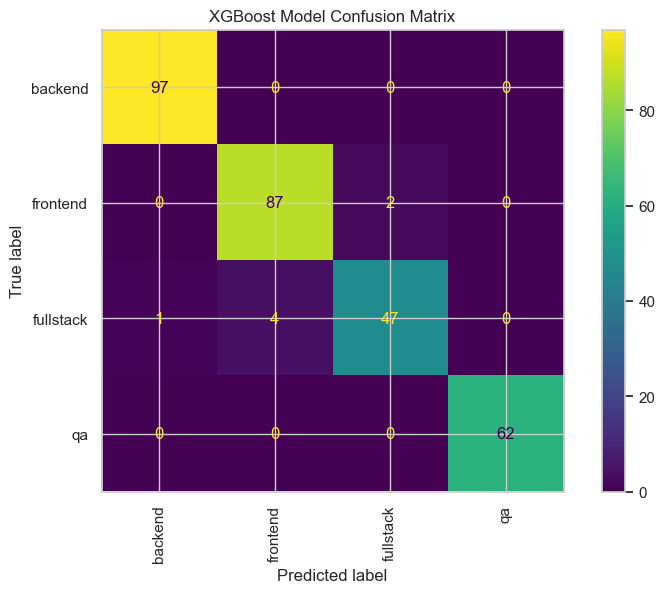

In [68]:
#XGBoost

import xgboost as xgb
#Pipeline
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        random_state=42, 
        use_label_encoder=False, 
        eval_metric='mlogloss'
    ))
])
#Train
print("Training the XGBoost model...")
xgb_model.fit(X_train, y_train_encoded)
print("Training complete.")

#prediction
y_pred_xgb = xgb_model.predict(X_test)

# In the report, we use the encoded test labels and provide the original names
print(classification_report(y_test_encoded, y_pred_xgb, target_names=le.classes_))

macro_f1_xgb = f1_score(y_test_encoded, y_pred_xgb, average='macro')
print(f"\nXGBoost Model (Macro F1 Score): {macro_f1_xgb:.4f}")

# For the confusion matrix, we provide the display labels
ConfusionMatrixDisplay.from_estimator(
    xgb_model, 
    X_test, 
    y_test_encoded, # Use encoded y
    xticks_rotation='vertical', 
    display_labels=le.classes_ # Use original class names for the plot
)
plt.title('XGBoost Model Confusion Matrix')
plt.show()

In [77]:
#Model Comparison

# Create a dictionary to hold the final results from all experiments
results = {
    'Model': [
        'Logistic Regression', 
        'LightGBM', 
        'XGBoost'
    ],
    'Macro F1 Score': [
        macro_f1_base, 
        macro_f1_improved, 
        macro_f1_xgb
    ]
}

results_df = pd.DataFrame(results).sort_values(by='Macro F1 Score', ascending=False)

#final results table
print("Models Comparison:")
display(results_df)

Models Comparison:


,Model,Macro F1 Score
0,Logistic Regression,0.980786
1,LightGBM,0.980718
2,XGBoost,0.973058


C:\Users\mazar\AppData\Local\Temp\ipykernel_24660\3704248965.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


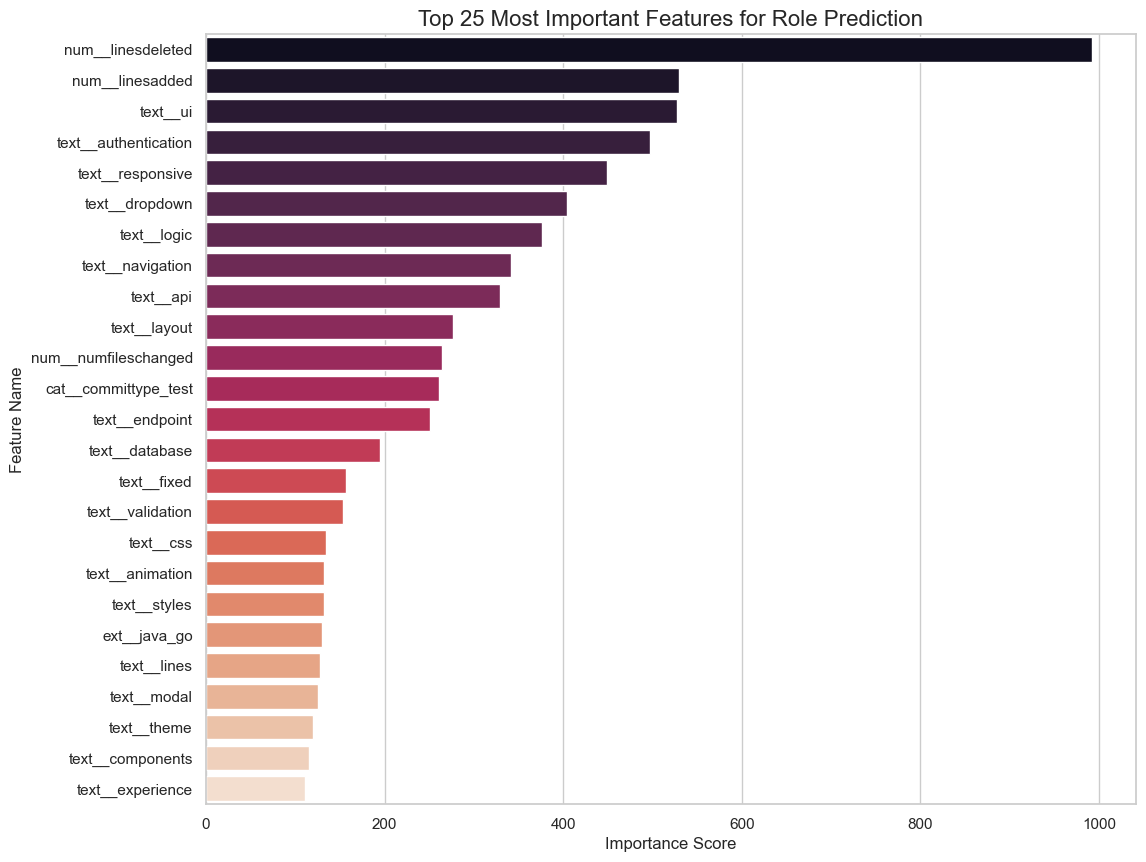

In [76]:
#Model Interpretation and Feature Importance
import seaborn as sns
#get the trained classifier step from the improved model pipeline
lgbm_classifier =improved_model.named_steps['classifier']

#get the feature names from the preprocessor step
# This correctly gets names for one-hot encoded, TF-IDF, and numeric features
feature_names =improved_model.named_steps['preprocessor'].get_feature_names_out()
feature_importances = lgbm_classifier.feature_importances_

#df creation for seeing things better
importance_df =pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)


#top 25 important features
plt.figure(figsize=(12, 10))
sns.barplot(
    x='importance',
    y='feature',
    data=importance_df.head(25),
    palette='rocket'
)
plt.title('Top 25 Most Important Features for Role Prediction', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.show()

In [74]:
#Qualitative Error Analysis

results_df =X_test.copy()
results_df['true_role'] =y_test_encoded
results_df['predicted_role'] =y_pred_improved


pd.set_option('display.max_colwidth', 200)

display(
    results_df[
        (results_df['true_role']=='fullstack') & 
        (results_df['predicted_role']=='backend')
    ].head()
)

,committype,numfileschanged,linesadded,linesdeleted,numcommentsadded,commitmessage,extensions_list,true_role,predicted_role


In [75]:
#Hyperparameter Tuning

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

#Define the hyperparameter search space
#we tell the search what settings to try for the classifier step of our pipeline.
param_dist = {
    'classifier__n_estimators': randint(150, 500),
    'classifier__learning_rate': uniform(0.01, 0.2),
    'classifier__num_leaves': randint(20, 50),
    'classifier__max_depth': randint(5, 15),
}


random_search = RandomizedSearchCV(
    estimator=improved_model,          #LightGBM pipeline
    param_distributions=param_dist,
    n_iter=25,                         
    cv=3,                             
    scoring='f1_macro',                
    random_state=42,
    n_jobs=-1,                       
    verbose=1                          #shows progress
)

#start
random_search.fit(X_train, y_train_encoded)
print("Tuning complete")

#get the best model
print("\nBest Hyperparameters Found")
print(random_search.best_params_)

best_tuned_model = random_search.best_estimator_
y_pred_tuned = best_tuned_model.predict(X_test)

print("\n--- Tuned Model Performance ---")
print(classification_report(y_test_encoded, y_pred_tuned))

macro_f1_tuned = f1_score(y_test_encoded, y_pred_tuned, average='macro')
print(f"Final Tuned Model (Macro F1 Score): {macro_f1_tuned:.4f}")

results_df.loc[2] = ['Tuned (LightGBM)', macro_f1_tuned]
display(results_df)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8620
[LightGBM] [Info] Number of data points in the train set: 1200, number of used features: 175
[LightGBM] [Info] Start training from score -1.131652
[LightGBM] [Info] Start training from score -1.217959
[LightGBM] [Info] Start training from score -1.757358
[LightGBM] [Info] Start training from score -1.564624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

C:\Users\mazar\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


ValueError: cannot set a row with mismatched columns